### 5.3.1 특성 추출

In [1]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights="imagenet",
                  include_top=False,
                  input_shape=(150,150,3))

2022-04-19 08:45:13.818248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 08:45:13.850341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 08:45:13.850562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 08:45:13.851518: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

1. 데이터 증식을 사용하지 않는 빠른 특성 추출

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = "./Dataset/cats-vs-dogs"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

def extract_features(directory, sample_count):
      features = np.zeros(shape=(sample_count, 4, 4, 512))
      labels = np.zeros(shape=(sample_count))
      
      generator = datagen.flow_from_directory(
            directory,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode = "binary"
      )
      
      i = 0
      for inputs_batch, labels_batch in generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
            if i * batch_size >= sample_count:
                  break
      return features, labels

train_features, train_labels = extract_features(train_dir, 1999)
validation_features, validation_lables = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 1999 images belonging to 2 classes.


2022-04-19 08:45:16.785857: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202
2022-04-19 08:45:19.396414: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-19 08:45:19.396496: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-19 08:45:19.877332: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_features = np.reshape(train_features, (1999, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation="relu", input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer=optimizers.RMSprop(learning_rate = 2e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data = (validation_features, validation_lables))

Epoch 1/30
100/100 [==============================] - 1s 10ms/step - loss: 0.5929 - accuracy: 0.6678 - val_loss: 0.4412 - val_accuracy: 0.8350
Epoch 2/30
100/100 [==============================] - 1s 7ms/step - loss: 0.4366 - accuracy: 0.8094 - val_loss: 0.3629 - val_accuracy: 0.8610
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3597 - accuracy: 0.8519 - val_loss: 0.3183 - val_accuracy: 0.8800
Epoch 4/30
100/100 [==============================] - 1s 7ms/step - loss: 0.3222 - accuracy: 0.8589 - val_loss: 0.2963 - val_accuracy: 0.8850
Epoch 5/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2890 - accuracy: 0.8839 - val_loss: 0.2823 - val_accuracy: 0.8860
Epoch 6/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2628 - accuracy: 0.8874 - val_loss: 0.2664 - val_accuracy: 0.8950
Epoch 7/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2450 - accuracy: 0.9045 - val_loss: 0.2837 - val_accuracy: 0.8730
Epoch

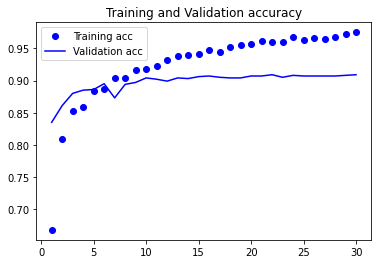

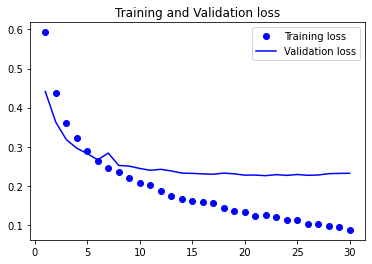

In [7]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

2. 데이터 증식을 사용한 특성 추출

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
print("conv_base를 동결하기 전 훈련되는 가중치의 수: ", len(model.trainable_weights))

conv_base.trainable = False
print("conv_base를 동결한 후 훈련되는 가중치의 수: ", len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수:  30
conv_base를 동결한 후 훈련되는 가중치의 수:  4


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150, 150),
                                                    batch_size = 20,
                                                    class_mode = "binary")

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size = (150, 150),
                                                        batch_size = 20,
                                                        class_mode = "binary")

model.compile(loss = "binary_crossentropy",
              optimizer = optimizers.RMSprop(lr=2e-5),
              metrics = ["accuracy"])

history = model.fit(train_generator,
                    steps_per_epoch = 100,
                    epochs = 30,
                    validation_data = validation_generator,
                    validation_steps = 50,
                    verbose = 2)

Found 1999 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 31s - loss: 0.5953 - accuracy: 0.6923 - val_loss: 0.4805 - val_accuracy: 0.7740 - 31s/epoch - 314ms/step
Epoch 2/30
100/100 - 36s - loss: 0.4898 - accuracy: 0.7809 - val_loss: 0.3795 - val_accuracy: 0.8500 - 36s/epoch - 358ms/step
Epoch 3/30
100/100 - 35s - loss: 0.4390 - accuracy: 0.8014 - val_loss: 0.3352 - val_accuracy: 0.8640 - 35s/epoch - 353ms/step
Epoch 4/30
100/100 - 34s - loss: 0.4028 - accuracy: 0.8219 - val_loss: 0.3088 - val_accuracy: 0.8750 - 34s/epoch - 337ms/step
Epoch 5/30
100/100 - 36s - loss: 0.3893 - accuracy: 0.8239 - val_loss: 0.2898 - val_accuracy: 0.8850 - 36s/epoch - 358ms/step
Epoch 6/30
100/100 - 31s - loss: 0.3694 - accuracy: 0.8344 - val_loss: 0.2860 - val_accuracy: 0.8860 - 31s/epoch - 305ms/step
Epoch 7/30
100/100 - 31s - loss: 0.3529 - accuracy: 0.8484 - val_loss: 0.2761 - val_accuracy: 0.8780 - 31s/epoch - 306ms/step
Epoch 8/30
100/100 - 36s - loss: 0

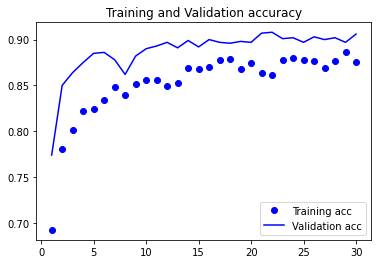

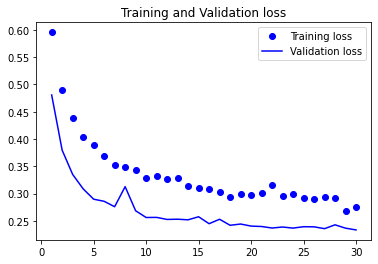

In [15]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

In [17]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = (150, 150),
                                                  batch_size = 20,
                                                  class_mode = "binary")

test_loss, test_acc = model.evaluate_generator(test_generator, steps = 50)
print("test acc : ", test_acc)

Found 1000 images belonging to 2 classes.


/tmp/ipykernel_3425/1334733140.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps = 50)


test acc :  0.8960000276565552
